In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from sklearn.metrics import confusion_matrix
import timm

In [ ]:
# Custom Dataset
class TensorDataset(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.files = [f for f in os.listdir(folder_path) if f.endswith('.pt')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name = self.files[idx]
        file_path = os.path.join(self.folder_path, file_name)
        tensor = torch.load(file_path, weights_only=True)
        if tensor.shape[0] == 1:
            tensor = tensor.repeat(3, 1, 1)

        # Extract class_id
        class_id = int(file_name.split('-')[1])

        return tensor, class_id

In [ ]:
# Path to tensors
hamm_tensor_path = '/content/drive/MyDrive/SEM_4/SPEECH/UrbanSound8K/Hamm_Tensor'
dataset = TensorDataset(hamm_tensor_path)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Epoch     Train Loss     Train Acc      Val Loss       Val Acc        
----------------------------------------------------------------------
1         0.9279         69.86         0.6245         80.54         
2         0.3444         88.60         0.4350         85.69         
3         0.2018         93.39         0.3349         89.07         
4         0.0487         98.60         0.2413         93.42         
5         0.0167         99.64         0.2263         93.42         
6         0.0070         99.81         0.2145         95.02         
7         0.0018         99.96         0.2152         94.73         
8         0.0007         99.99         0.2180         94.79         
9         0.0005         100.00        0.2212         95.13         
10        0.0003         100.00        0.2221         95.13         


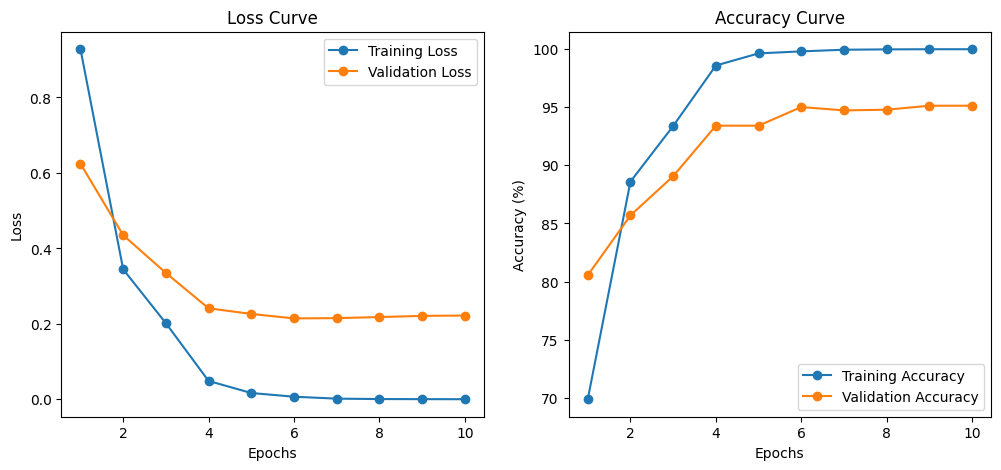

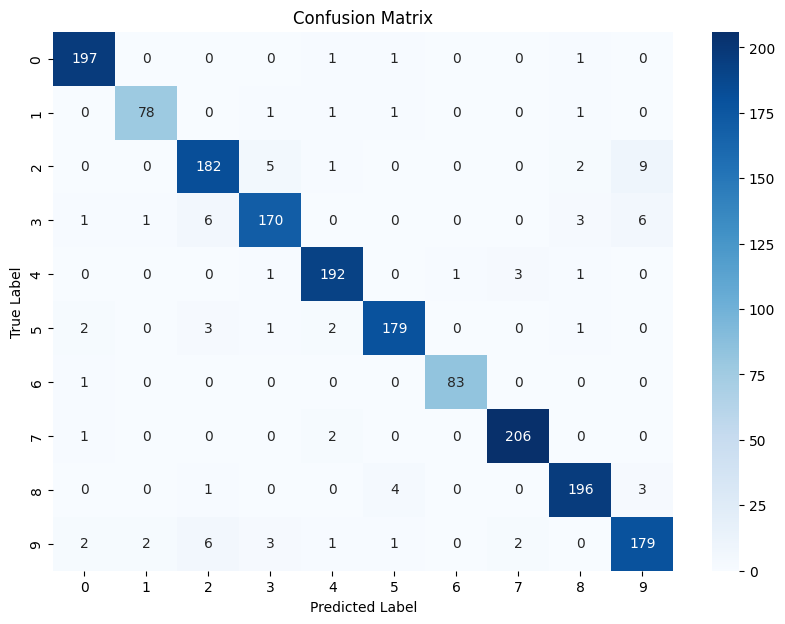

In [ ]:
# Load pretrained model
model = timm.create_model('vit_tiny_patch16_224', pretrained=True)
num_features = model.head.in_features
model.head = nn.Linear(num_features, 10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

# Training settings
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

print(f"{'Epoch':<10}{'Train Loss':<15}{'Train Acc':<15}{'Val Loss':<15}{'Val Acc':<15}")
print("-" * 70)

for epoch in range(num_epochs):
    model.train()
    total_loss, correct_train, total_train = 0, 0, 0

    # Training Loop
    for tensors, labels in train_loader:
        tensors, labels = tensors.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(tensors)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct_train += (outputs.argmax(dim=1) == labels).sum().item()
        total_train += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    # Validation Loop
    model.eval()
    correct_val, total_val, val_loss = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for tensors, labels in val_loader:
            tensors, labels = tensors.to(device), labels.to(device)
            outputs = model(tensors)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct_val / total_val)

    print(f"{epoch+1:<10}{train_losses[-1]:<15.4f}{train_accuracies[-1]:<14.2f}{val_losses[-1]:<15.4f}{val_accuracies[-1]:<14.2f}")
    scheduler.step()

# Plot Loss & Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs"), plt.ylabel("Loss"), plt.title("Loss Curve"), plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy", marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs"), plt.ylabel("Accuracy (%)"), plt.title("Accuracy Curve"), plt.legend()
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label'), plt.ylabel('True Label'), plt.title('Confusion Matrix')
plt.show()

Epoch     Train Loss     Train Acc      Val Loss       Val Acc        
----------------------------------------------------------------------
1         0.9630         68.30         0.5812         79.11         
2         0.3872         87.27         0.3650         88.21         
3         0.2009         93.39         0.4267         85.86         
4         0.0552         98.15         0.2460         93.19         
5         0.0195         99.36         0.2556         93.07         


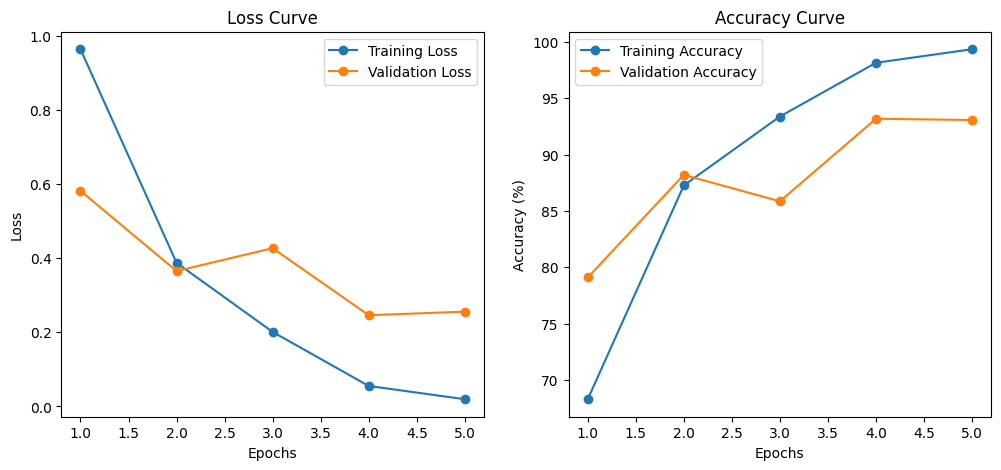

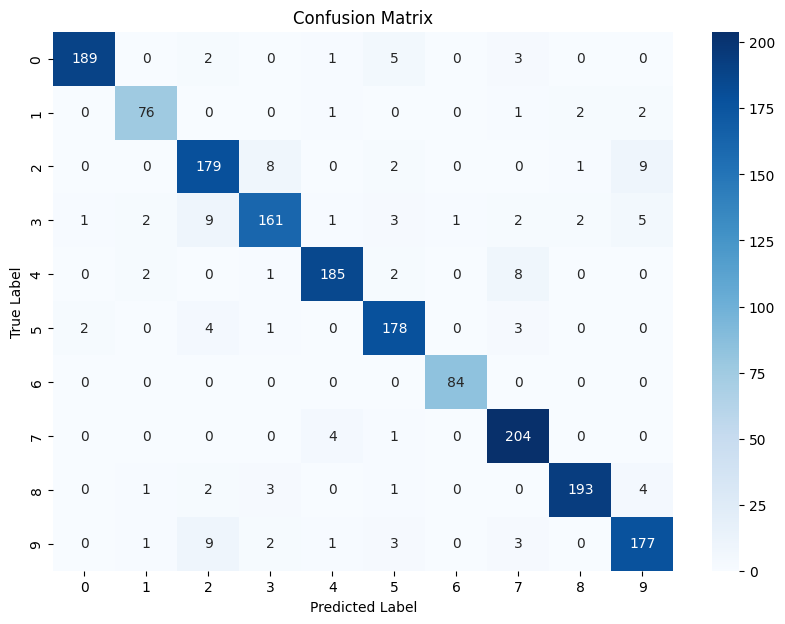

In [ ]:
model = timm.create_model('vit_tiny_patch16_224', pretrained=True)
num_features = model.head.in_features
model.head = nn.Linear(num_features, 10)
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

# Training settings
num_epochs = 5
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

print(f"{'Epoch':<10}{'Train Loss':<15}{'Train Acc':<15}{'Val Loss':<15}{'Val Acc':<15}")
print("-" * 70)

for epoch in range(num_epochs):
    model.train()
    total_loss, correct_train, total_train = 0, 0, 0

    # Training Loop
    for tensors, labels in train_loader:
        tensors, labels = tensors.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(tensors)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct_train += (outputs.argmax(dim=1) == labels).sum().item()
        total_train += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    # Validation Loop
    model.eval()
    correct_val, total_val, val_loss = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for tensors, labels in val_loader:
            tensors, labels = tensors.to(device), labels.to(device)
            outputs = model(tensors)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct_val / total_val)

    print(f"{epoch+1:<10}{train_losses[-1]:<15.4f}{train_accuracies[-1]:<14.2f}{val_losses[-1]:<15.4f}{val_accuracies[-1]:<14.2f}")
    scheduler.step()

# Plot Loss & Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs"), plt.ylabel("Loss"), plt.title("Loss Curve"), plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy", marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs"), plt.ylabel("Accuracy (%)"), plt.title("Accuracy Curve"), plt.legend()
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label'), plt.ylabel('True Label'), plt.title('Confusion Matrix')
plt.show()